<h2>Introduction</h2>
<p>This notebook aims to develop a demand forecasting model for supply chain management.
Using historical sales data from Rossmann stores, the model will predict future sales
to optimize inventory levels and improve customer satisfaction.</p>
<p>We will be using multiple models to select the best alternative and predict the sale.</p>

<h3>Useful Functions</h3>

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
import xgboost as xgb
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

In [103]:
# Definiing the loss functions
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

def try_model(model):
    # Fit the model
    model.fit(X_train_encoded, y_train)

    # Generate predictions
    yhat_train = model.predict(X_train_encoded)
    yhat_test = model.predict(X_test_encoded)

    # Compute RMSE
    train_rmse = mean_squared_error(y_train, yhat_train, squared=False)
    val_rmse = mean_squared_error(y_test, yhat_test, squared=False)
    return train_rmse, val_rmse, rmspe(y_test, yhat_test)

<H2>Exploratory Data Analysis</H2>

In [3]:
df_sales_raw = pd.read_csv("train.csv", low_memory=False)
df_store_raw = pd.read_csv("store.csv", low_memory=False)
df_test = pd.read_csv("test.csv", low_memory=False)

In [4]:
df_sales_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
df_test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
df_store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
df_sales_raw.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


In [8]:
df_store_raw.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [9]:
df_store_raw['StoreType'].value_counts()

StoreType
a    602
d    348
c    148
b     17
Name: count, dtype: int64

<h2>Missing Data Evaluation</h2>

In [10]:
def get_missing_columns(df):
    return list(df.columns[df.describe(include = 'all').loc['count']<len(df)])

In [11]:
get_missing_columns(df_store_raw)

['CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

<p>The above mention columns by design could be empty and hence we need not to fill them with approximations</p>

In [12]:
get_missing_columns(df_sales_raw)

[]

<p>This is a good thing that we are not missing as sales information.</p>

In [13]:
df_sales_raw.shape

(1017209, 9)

In [14]:
merged_df = df_sales_raw.merge(df_store_raw, how='left', on='Store')

In [15]:
merged_df.shape

(1017209, 18)

In [34]:
merged_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,7,2015
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,7,2015
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,7,2015
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,7,2015
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,7,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1,b,...,150.0,9.0,2006.0,0,NaN,NaN,NaN,1,1,2013
1016827,733,2,2013-01-01,10765,2377,1,0,a,1,b,...,860.0,10.0,1999.0,0,NaN,NaN,NaN,1,1,2013
1016863,769,2,2013-01-01,5035,1248,1,0,a,1,b,...,840.0,NaN,NaN,1,48.0,2012.0,"Jan,Apr,Jul,Oct",1,1,2013
1017042,948,2,2013-01-01,4491,1039,1,0,a,1,b,...,1430.0,NaN,NaN,0,NaN,NaN,NaN,1,1,2013


In [37]:
merged_df.info

<bound method DataFrame.info of          Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1016776    682          2 2013-01-01   3375        566     1      0   
1016827    733          2 2013-01-01  10765       2377     1      0   
1016863    769          2 2013-01-01   5035       1248     1      0   
1017042    948          2 2013-01-01   4491       1039     1      0   
1017190   1097          2 2013-01-01   5961       1405     1      0   

        StateHoliday  SchoolHoliday StoreType  ... CompetitionDistance  \
0                  0              1      

In [16]:
merged_test_df = df_test.merge(df_store_raw, how='left', on='Store')

In [38]:
merged_test_df.info

<bound method DataFrame.info of           Id  Store  DayOfWeek        Date  Open  Promo StateHoliday  \
0          1      1          4  2015-09-17   1.0      1            0   
1          2      3          4  2015-09-17   1.0      1            0   
2          3      7          4  2015-09-17   1.0      1            0   
3          4      8          4  2015-09-17   1.0      1            0   
4          5      9          4  2015-09-17   1.0      1            0   
...      ...    ...        ...         ...   ...    ...          ...   
41083  41084   1111          6  2015-08-01   1.0      0            0   
41084  41085   1112          6  2015-08-01   1.0      0            0   
41085  41086   1113          6  2015-08-01   1.0      0            0   
41086  41087   1114          6  2015-08-01   1.0      0            0   
41087  41088   1115          6  2015-08-01   1.0      0            0   

       SchoolHoliday StoreType Assortment  CompetitionDistance  \
0                  0         c       

In [56]:
merged_test_df

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,17,9,2015
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",17,9,2015
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN,17,9,2015
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN,17,9,2015
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN,17,9,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,8,2015
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,1,8,2015
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,1,8,2015
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,1,8,2015


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


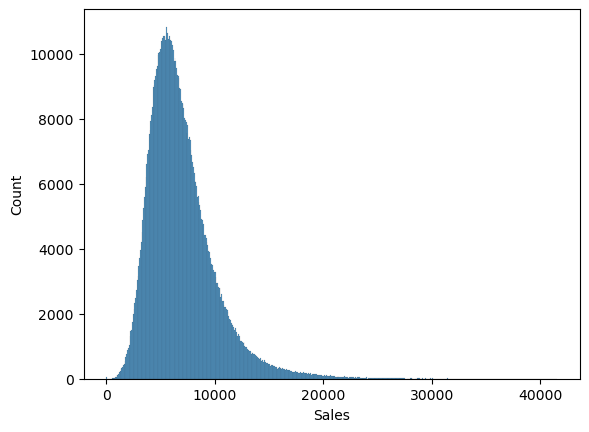

In [39]:
round(merged_df.describe().T,2)
merged_df = merged_df[merged_df.Open==1].copy()
sns.histplot(data=merged_df, x='Sales');

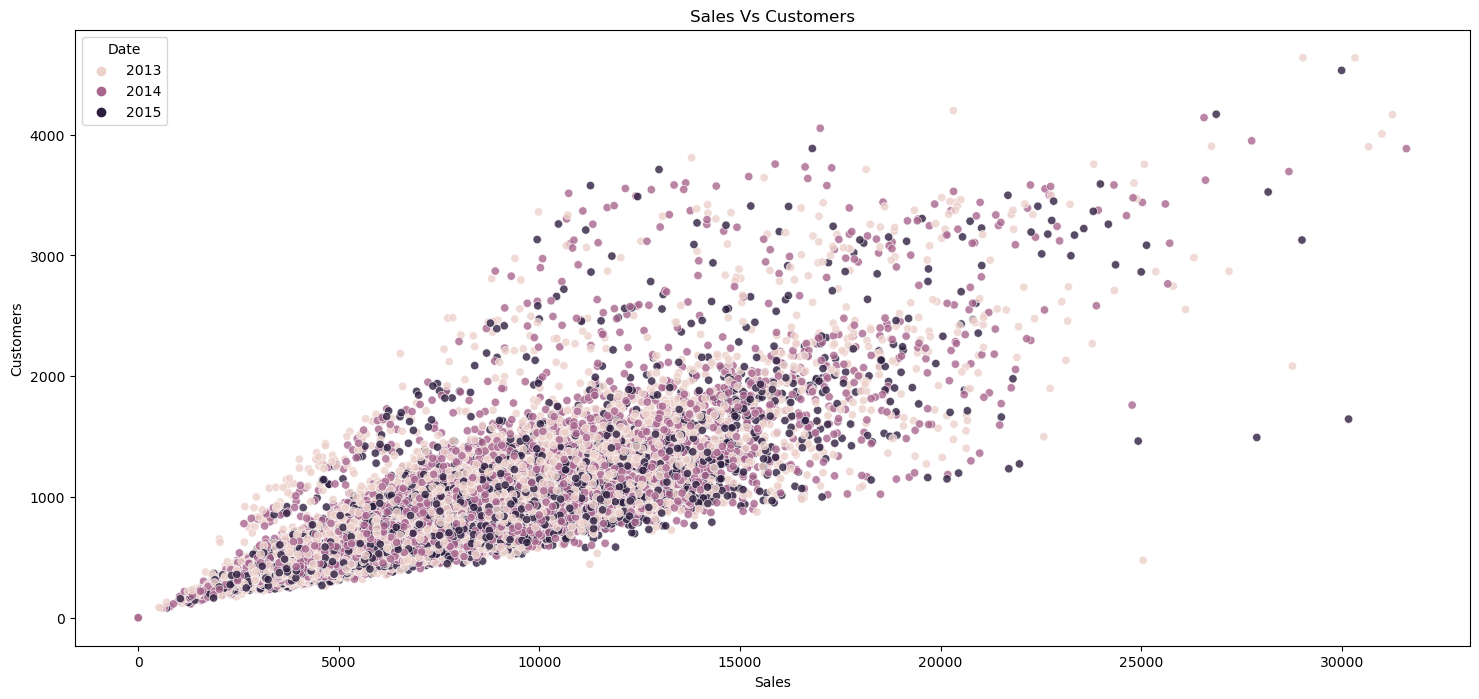

In [24]:
plt.figure(figsize=(18,8))
merged_df['Date'] = pd.to_datetime(merged_df.Date)
temp_df = merged_df.sample(40000)
sns.scatterplot(x=temp_df.Sales, y=temp_df.Customers, hue=temp_df.Date.dt.year, alpha=0.8)
plt.title("Sales Vs Customers")
plt.show()

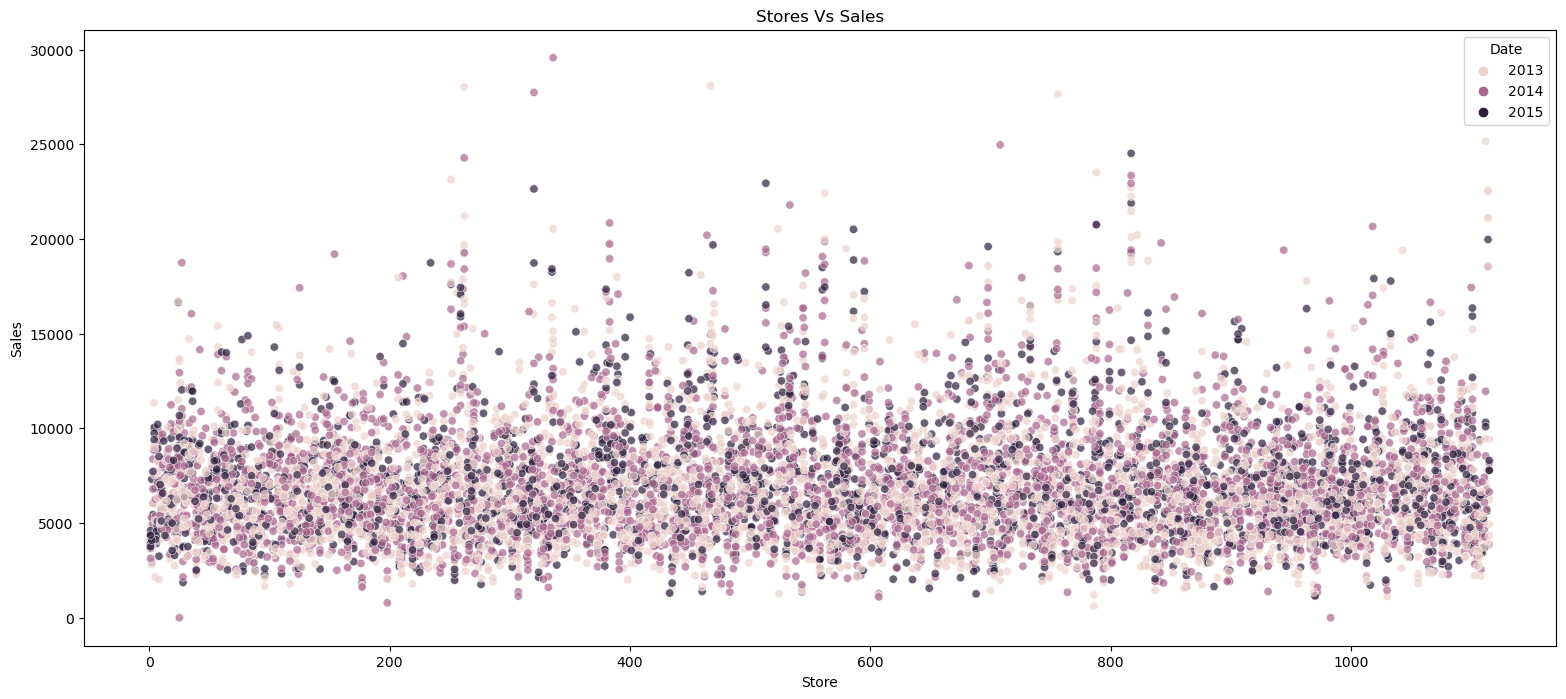

In [26]:
plt.figure(figsize=(19,8))
temp_df = merged_df.sample(10000)
sns.scatterplot(x=temp_df.Store, y=temp_df.Sales, hue=temp_df.Date.dt.year, alpha=0.7)
plt.title("Stores Vs Sales")
plt.show()

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

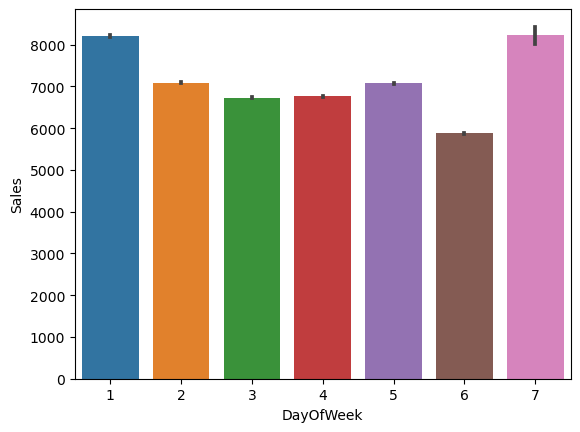

In [27]:
sns.barplot(data=merged_df, x='DayOfWeek', y='Sales')

<Axes: xlabel='Promo', ylabel='Sales'>

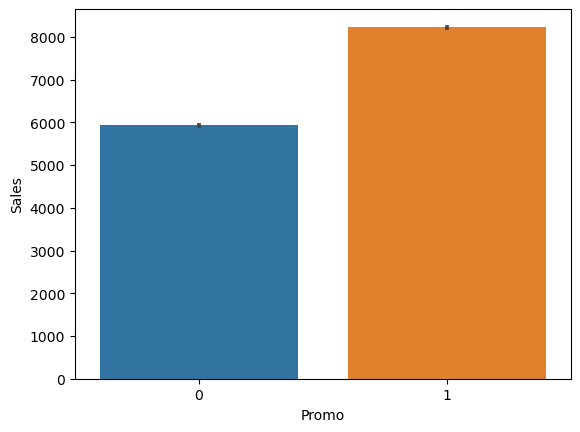

In [28]:
sns.barplot(data=merged_df, x='Promo', y='Sales')

In [53]:
merged_df['Day'] = merged_df.Date.dt.day
merged_df['Month'] = merged_df.Date.dt.month
merged_df['Year'] = merged_df.Date.dt.year
merged_test_df['Day'] = merged_test_df.Date.dt.day
merged_test_df['Month'] = merged_test_df.Date.dt.month
merged_test_df['Year'] = merged_test_df.Date.dt.year

<Axes: xlabel='Year', ylabel='Sales'>

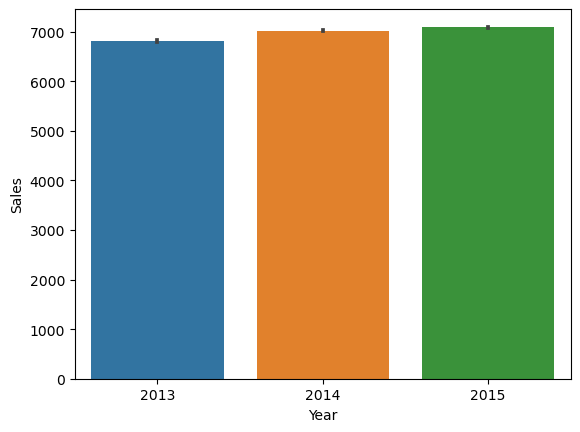

In [32]:
sns.barplot(data=merged_df, x='Year', y='Sales')

<p>The sales year over year are showing upwards trend. Means that the sales are going up on an average in all stores</p>

<Axes: xlabel='Month', ylabel='Sales'>

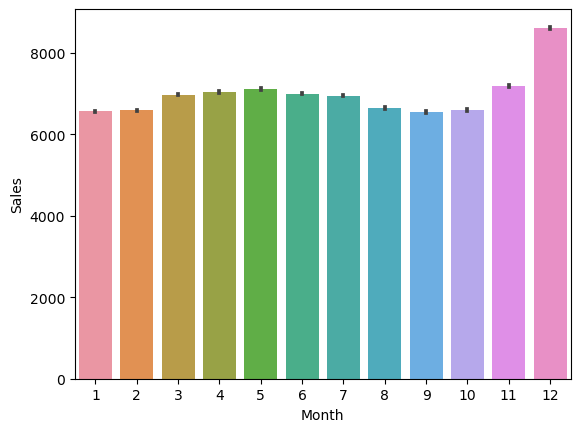

In [40]:
sns.barplot(data=merged_df, x='Month', y='Sales')

In [41]:
merged_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Day', 'Month', 'Year'],
      dtype='object')

In [44]:
merged_df['Date'] = pd.to_datetime(merged_df.Date)
merged_test_df['Date'] = pd.to_datetime(merged_test_df.Date)

In [45]:
merged_df.Date.min(), merged_df.Date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [46]:
merged_test_df.Date.min(), merged_test_df.Date.max()

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

<p>The training data is from 1st Jan 2013 to 31st July 2015. The test data is for next 45 days.</p>

<H2>Data Preparation</H2>

<p>The data set is already divided into training and test. So we don't have to split it further</p>
<p>Fields that are known before hand are "DayOfWeek", "Date", "Open", "Promo", "StateHoliday", "StoreType", "Assortment","CompetitionDistance", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2", "Promo2SinceWeek", "Promo2SinceYear","PromoInterval" </p>
<p> Field that we need to predict Sales. Let's start with a smaller subset of the feilds then expand it.</p>

In [47]:
input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'StoreType', 'Assortment', 'Day', 'Month', 'Year']

In [48]:
focus_col = 'Sales'

In [49]:
merged_df[input_cols].nunique()

Store           1115
DayOfWeek          7
Promo              2
StateHoliday       4
StoreType          4
Assortment         3
Day               31
Month             12
Year               3
dtype: int64

In [59]:
X= merged_df[input_cols].copy()
Y= merged_df[focus_col].copy()

In [63]:
ross_test_X = merged_test_df[input_cols].copy()

In [61]:
# Spliting the data into test and train as we don't have sales numbers for the test set.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
print(y_train.mean())
print(y_test.mean())

6956.927428487683
6949.861764932289


In [62]:
numeric_cols = ['Store', 'Day', 'Month', 'Year']
categorical_cols = ['DayOfWeek', 'Promo', 'StateHoliday', 'StoreType', 'Assortment']

<h3>Scaling, Imputation and Encoding</h3>

In [64]:
imputer = SimpleImputer(strategy='mean').fit(X_train[numeric_cols])
X_train[numeric_cols] = imputer.transform(X_train[numeric_cols])
X_test[numeric_cols] = imputer.transform(X_test[numeric_cols])
ross_test_X[numeric_cols] = imputer.transform(ross_test_X[numeric_cols])

In [68]:
scaler = MinMaxScaler().fit(X_train[numeric_cols])
X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])
ross_test_X[numeric_cols] = scaler.transform(ross_test_X[numeric_cols])

In [71]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(X_train[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
X_train[encoded_cols] = encoder.transform(X_train[categorical_cols])
X_test[encoded_cols] = encoder.transform(X_test[categorical_cols])
ross_test_X[encoded_cols] = encoder.transform(ross_test_X[categorical_cols])

In [80]:
X_train_encoded= X_train[numeric_cols + encoded_cols]
X_test_encoded = X_test[numeric_cols + encoded_cols]
ross_test_X_encoded = ross_test_X[numeric_cols + encoded_cols]

In [86]:
linreg = LinearRegression()
linreg.fit(X_train_encoded, y_train)

LinearRegression()

In [87]:
yhat = linreg.predict(X_test_encoded)
yhat

array([6130., 5542., 6008., ..., 5572., 8356., 6274.])

In [88]:
rmspe(yhat,y_test)

0.5103325063385462

In [104]:
from sklearn.metrics import mean_squared_error
mean_squared_error(yhat,y_test, squared=False)

2752.079444636268

In [105]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

In [106]:
try_model(LinearRegression())

(2759.62007854606, 2752.079444636268, 0.39331122275423025)

In [107]:
try_model(Ridge())

(2759.606897890129, 2752.039458316244, 0.3934904649030482)

In [108]:
try_model(Lasso())

(2759.753360571528, 2751.9700211164986, 0.393412082910832)

In [109]:
try_model(ElasticNet())

(2903.2623954468754, 2890.9484248872036, 0.4109525252055897)

In [110]:
try_model(SGDRegressor())

(2760.436960112563, 2752.727503753323, 0.39777123237135775)

In [114]:
tree = DecisionTreeRegressor(random_state=0)
try_model(tree)

(0.0, 1606.9791205644128, 0.2538932913368085)

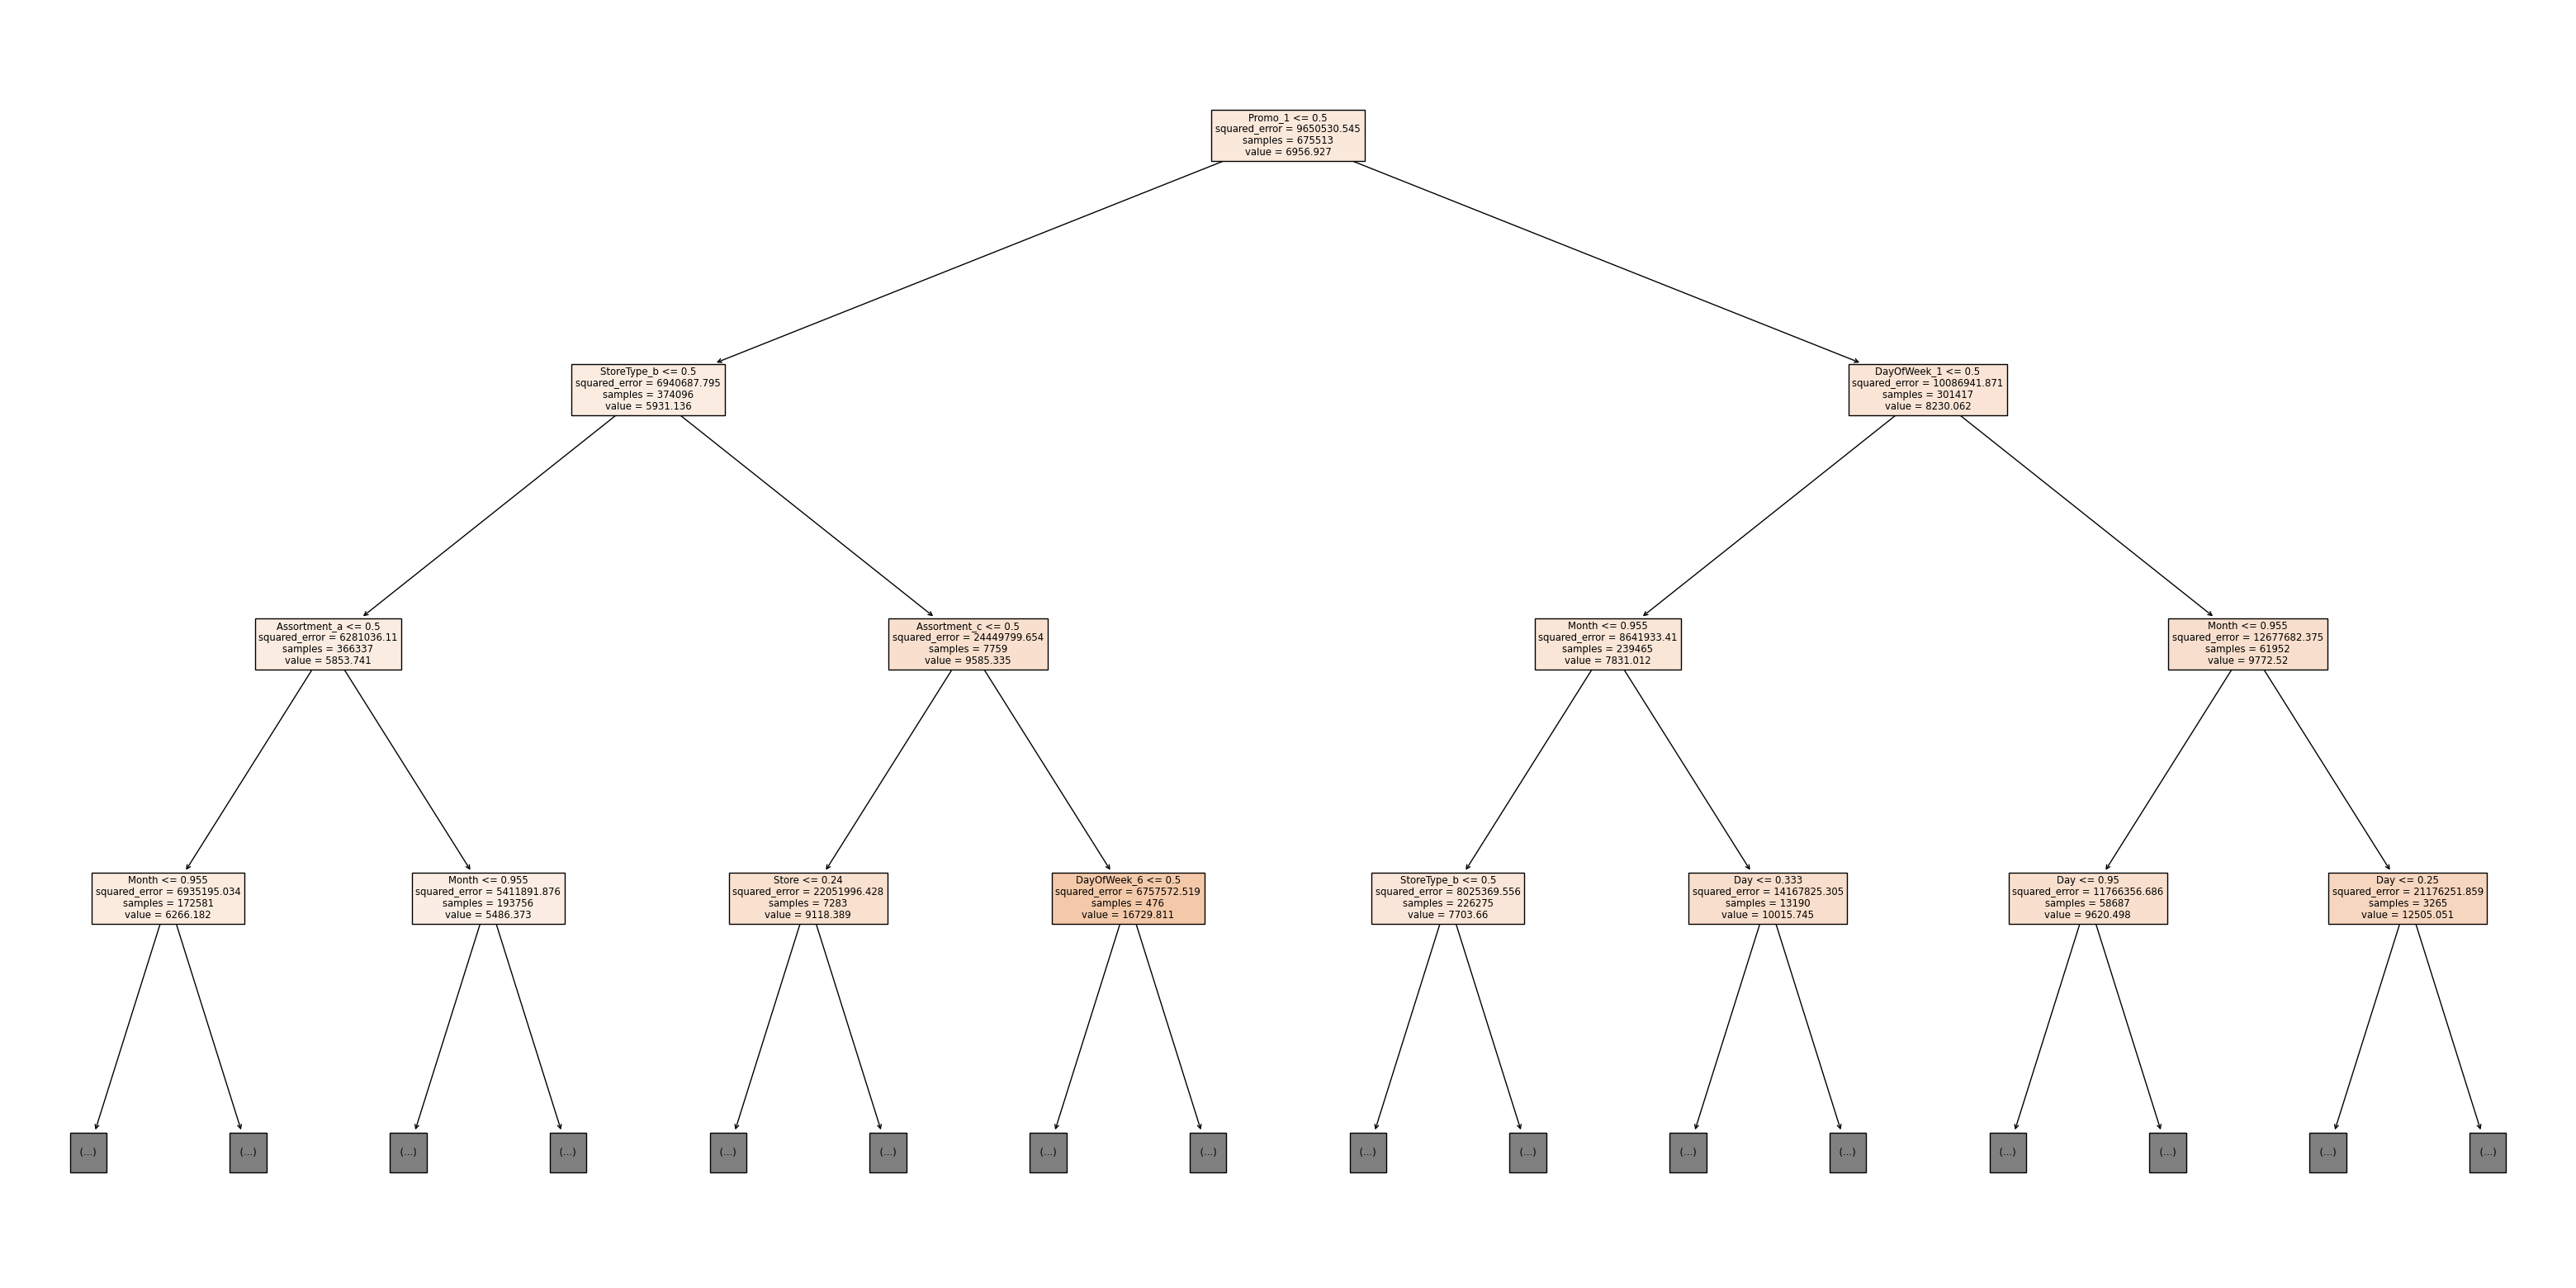

In [115]:
plt.figure(figsize=(40, 20))
plot_tree(tree, max_depth=3, filled=True, feature_names=numeric_cols+encoded_cols);

In [112]:
from sklearn.ensemble import RandomForestRegressor

In [119]:
%%time
rf = RandomForestRegressor(random_state=0, n_jobs=-1)
try_model(rf)

CPU times: user 5min 58s, sys: 6.35 s, total: 6min 5s
Wall time: 54.4 s


(472.4879581088437, 1246.328642373271, 0.16051035072279088)

In [120]:
rf.feature_importances_

array([5.98071554e-01, 5.27170243e-02, 4.92012253e-02, 1.55667548e-02,
       3.33675158e-02, 4.35011313e-03, 2.59754528e-03, 2.45837014e-03,
       4.96150167e-03, 6.47943476e-03, 4.75627954e-03, 6.36549890e-02,
       7.17444450e-02, 1.23290744e-03, 2.27526136e-04, 4.46466441e-05,
       1.92832953e-05, 1.44670229e-02, 2.43638073e-02, 1.05862748e-02,
       1.36674033e-02, 8.99423820e-03, 4.50426756e-03, 1.19658694e-02])

In [121]:
importance_df = pd.DataFrame({
    'feature': numeric_cols+encoded_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)
importance_df.head(10)

,feature,importance
0,Store,0.598072
12,Promo_1,0.071744
11,Promo_0,0.063655
1,Day,0.052717
2,Month,0.049201
4,DayOfWeek_1,0.033368
18,StoreType_b,0.024364
3,Year,0.015567
17,StoreType_a,0.014467
20,StoreType_d,0.013667


<Axes: xlabel='importance', ylabel='feature'>

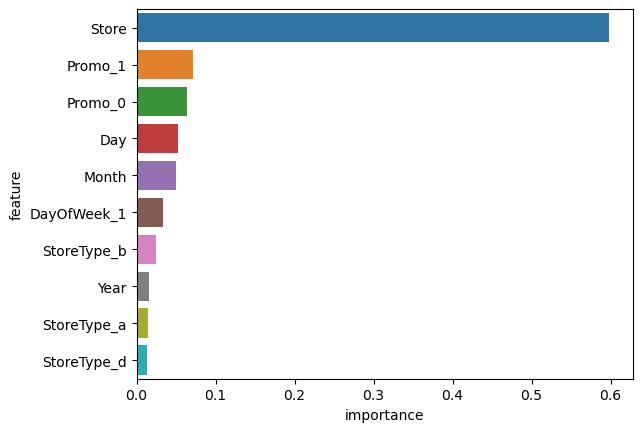

In [122]:
sns.barplot(data=importance_df.head(10), x='importance', y='feature')